In [1]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as mplt
import os
from numpy import asarray
from keras import preprocessing
from keras.models import Sequential as Squel , load_model as lmd
from keras.layers import Conv2D as Cn2, Dropout as Drpot , Dense as Dns , Flatten as Flt , Conv2DTranspose as Cn2Trp , BatchNormalization as Btnorm , LeakyReLU as Lkyr, Reshape as Rs , Input as Ipt


import tensorflow as tsf
import os
import numpy as nmy



Using TensorFlow backend.


In [2]:
pth_celbs = []
training_celbs = "C:\proj_imgs\imgs_celbs\imgs_celbs"
for pth in os.listdir(training_celbs):
    if '.jpg' in pth:
        pth_celbs.append(os.path.join(training_celbs, pth))

nw_pth = pth_celbs[:50000]
len(nw_pth)
crop = (30, 55, 150, 175)
type(nw_pth)


list

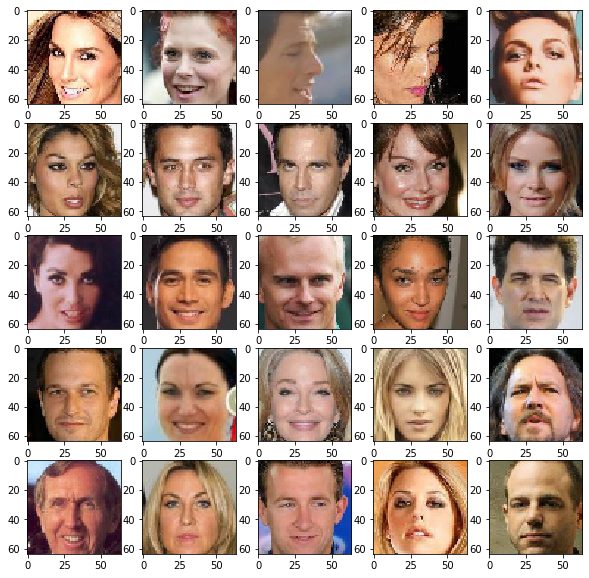

In [3]:
im = [nmy.array((Image.open(pth).crop(crop)).resize((64,64))) for pth in nw_pth]

_,xa = mplt.subplots(5,5, figsize = (10,10)) 
for u in range(5):
    for v in range(5):
        xa[u,v].imshow(im[5*u+v])
        xa[u,v].axis('on')

for u in range(len(im)):
    im[u] = ((im[u] - im[u].min())/(255 - im[u].min()))


In [4]:
im[0].shape

im=nmy.array(im)

train_data = im

print(train_data.shape)


noiz_size = 100
noiz_shape = (100,1)

genr=Squel()
genr.add(Dns(4*4*512,input_shape=[noiz_size]))
genr.add(Rs([4,4,512]))
genr.add(Cn2Trp(256, kernel_size=4, strides=2, padding="same"))
genr.add(Lkyr(alpha=0.2))
genr.add(Btnorm())
genr.add(Cn2Trp(128, kernel_size=4, strides=2, padding="same"))
genr.add(Lkyr(alpha=0.2))
genr.add(Btnorm())
genr.add(Cn2Trp(64, kernel_size=4, strides=2, padding="same"))
genr.add(Lkyr(alpha=0.2))
genr.add(Btnorm())
genr.add(Cn2Trp(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

genr.summary()
genr.compile(loss="binary_crossentropy",optimizer="SGD")


disr=Squel()
disr.add(Cn2(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
disr.add(Cn2(64, kernel_size=4, strides=2, padding="same"))
disr.add(Lkyr(0.2))
disr.add(Btnorm())
disr.add(Cn2(128, kernel_size=4, strides=2, padding="same"))
disr.add(Lkyr(0.2))
disr.add(Btnorm())
disr.add(Cn2(256, kernel_size=4, strides=2, padding="same"))
disr.add(Lkyr(0.2))
disr.add(Flt())
disr.add(Drpot(0.5))
disr.add(Dns(1,activation='sigmoid'))
disr.summary()
disr.compile(optimizer="SGD", loss='binary_crossentropy')

disr.trainable = False
gan_model= Squel([genr,disr])
gan_model.compile(optimizer='SGD',loss='binary_crossentropy')

epchs = 75
btc_len = 128
Disr_loss= []
Genr_loss = []




(50000, 64, 64, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None,

In [ ]:
for epch in range(epchs):
        print(f"Currently on Epch {epch+1}")

        
        for u in range(train_data.shape[0]//btc_len):

            if (u)%100 == 0:
                print(f"\tRight Now on btc no. {u} of {len(train_data)//btc_len}")

            noiz=nmy.random.uniform(-1,1,size=[btc_len,noiz_size])

            gen_image = genr.predict_on_batch(noiz)

            train_dataset = train_data[u*btc_len:(u+1)*btc_len]
            
            trn_label=nmy.ones(shape=(btc_len,1))
            disr.trainable = True
            d_loss1 = disr.train_on_batch(train_dataset,trn_lbl)

            
            trn_lbl=nmy.zeros(shape=(btc_len,1))
            d_loss2 = disr.train_on_batch(gen_image,trn_lbl)


            noiz=nmy.random.uniform(-1,1,size=[btc_len,noiz_size])
            trn_lbl=nmy.ones(shape=(btc_len,1))
            disr.trainable = False
          
            genr_loss = gan_model.train_on_batch(noiz, trn_lbl)
            Disr_loss.append(d_loss1+d_loss2)
            Genr_loss.append(genr_loss)


        if epch % 5 == 0:
            samples = 10
            x_fake = genr.predict(nmy.random.normal(loc=0, scale=1, size=(samples,100)))
            genr.save(f"C:/Saved_SGD/generator_{epch}.h5")
            disr.save(f"C:/Saved_SGD/discriminator_{epch}.h5")
            for k in range(samples):
                mplt.subplot(2, 5, k+1)
                mplt.imshow(x_fake[k].Rs(64,64,3))
                mplt.xticks([])
                mplt.yticks([])
                
                
            mplt.tight_layout()     
            mplt.show()
        print('Epch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epch+1, d_loss1, d_loss2, genr_loss))        
        print('Training is complete')




In [5]:
import cv2
samples = 5000
genr = lmd("C:/saved_model/generator_70.h5")
disr = lmd("C:/saved_model/discriminator70.h5")
x_fake = genr.predict(nmy.random.normal(loc=0, scale=1, size=(samples,100)))

for k in range(samples):
    x = cv2.cvtColor( (x_fake[k]*255).astype(nmy.uint8).reshape(64,64,3), cv2.COLOR_RGB2BGR)
    cv2.imwrite( f"fake_folder/{k}.jpg",x)



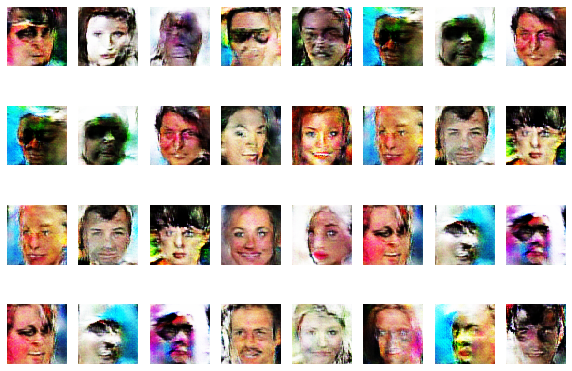

In [6]:
genr = lmd("C:/saved_model/generator_70.h5")
disr = lmd("C:/saved_model/discriminator70.h5")
samples = 25
x_fake = genr.predict(nmy.random.normal(loc=0, scale=1, size=(samples,100)))

                 
_,ax = mplt.subplots(4,8, figsize = (10,7)) 
for u in range(4):
    for v in range(8):
        ax[u,v].imshow(x_fake[5*u+v])
        ax[u,v].axis('off') 
